In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import torch
#import torchvision
from torch.utils.data import DataLoader
#from torchvision import transforms
from torch.utils.data import Dataset,SubsetRandomSampler,Sampler
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
import glob
from skimage import io, transform
from PIL import Image
import random
import PIL.ImageEnhance as ie
import copy
from torch.autograd import Variable
import PIL.Image as im
from math import floor
from torchvision.transforms import *
from numpy import linalg as LA
from scipy.stats import rankdata
from collections import OrderedDict

In [ ]:
%cd ../content/drive/My Drive

/content/drive/My Drive


In [ ]:
!ls

'Getting started.pdf'   model_quantized_and_trained.pt
 model01.pt	        monk_v1
 model1.pt	        plant-pathology-2020-fgvc7
 model.h5	        Quantised_model01.pt
 model_keras.h5         Quantised_model.h5
 model.pt


In [ ]:
root = "./plant-pathology-2020-fgvc7/images"

In [ ]:
df = pd.read_csv("./plant-pathology-2020-fgvc7/my_csv.csv")
csv_file=df.to_numpy()

In [ ]:
print(csv_file[:,1])

['multiple_diseases' 'healthy' 'rust' ... 'healthy' 'rust' 'scab']


In [ ]:
for i in range(len(csv_file[:,1])):
  if(csv_file[i,1]=='healthy'):
    csv_file[i,1]=0
  elif(csv_file[i,1]=="multiple_diseases"):
    csv_file[i,1]=1
  elif(csv_file[i,1]=="rust"):
    csv_file[i,1]=2
  elif(csv_file[i,1]=="scab"):
    csv_file[i,1]=3

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, root,csv_file, transform=None):
        self.root_dir = root
        self.transform = transform
        self.csv_file = csv_file
        

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv_file[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.csv_file[idx, 1]

        if self.transform:
            image = self.transform(image)
        return image,label

In [ ]:
transform=transforms.Compose([CenterCrop(512),RandomGrayscale(p=0.5),RandomHorizontalFlip(0.5),RandomRotation(180),RandomVerticalFlip(p=0.5),
                              ToTensor(),Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                           ])

In [ ]:
trainset = PlantDataset(root=root,csv_file =csv_file , transform=transform)
valset   = PlantDataset(root=root,csv_file =csv_file, transform=transform)

In [ ]:
def train_valid_split(dataset, test_size = 0.20, shuffle = False, random_seed = 0):
    length = dataset.__len__()
    indices = list(range(1,length))
    
    if shuffle == True:
        random.seed(random_seed)
        random.shuffle(indices)
    
    if type(test_size) is float:
        split = floor(test_size * length)
    elif type(test_size) is int:
        split = test_size
    else:
        raise ValueError('%s should be an int or a float' % str)
    return indices[split:], indices[:split]

In [ ]:
train_idx, valid_idx = train_valid_split(trainset, 0.20)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = DataLoader(dataset=trainset, sampler = train_sampler,batch_size =8)
valid_loader = DataLoader(dataset=valset, sampler = valid_sampler,batch_size =8)

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

In [ ]:
#!pip install efficientnet-pytorch

In [ ]:
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b7') 
#model.cuda()

In [ ]:
model.fc = nn.Sequential(nn.Linear(in_features=1000,out_features=320),nn.Dropout(p=0.3),nn.Linear(in_features = 320,out_features=4))


In [ ]:
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
import time

In [ ]:
ct = 0
for child in model.children():
  ct += 1
  if ct < 3:
      for param in child.parameters():
          param.requires_grad = False
  else:
    for param in child.parameters():
          param.requires_grad = True
print(ct)

4


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:

for epoch in range(10):  # loop over the dataset multiple times
  
    model.train()
    valid_losses=[]
    train_losses=[]
    
    for i,(inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(np.average(train_losses))
    correct =0
    total =0
    wrong=0
    model.eval()
    for inputs, labels in valid_loader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      
      output = model(inputs)
      loss = criterion(output,labels)
      valid_losses.append(loss.item())
      _, preds = torch.max(output.data, 1)
      correct += torch.sum(preds == labels)
      wrong += torch.sum(preds != labels)
      
    acc = (correct.float()) / ((correct+wrong).float())  
    valid_loss = np.average(valid_losses)
    print(valid_loss)
    print("accuracy =",(correct*100)/(correct+wrong))
    print(epoch)
      
          


print('Finished Training')


13.673967202449893
1.1714202476584392
accuracy = tensor(46, device='cuda:0')
0


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


1.3902054671402817
1.2273356046365655
accuracy = tensor(51, device='cuda:0')
1
1.34483809867403
1.0509772663531096
accuracy = tensor(57, device='cuda:0')
2
1.2821231269901925
1.103029339209847
accuracy = tensor(59, device='cuda:0')
3
1.1985488655147971
1.0199004100716633
accuracy = tensor(58, device='cuda:0')
4
1.1786286508725894
1.003952470810517
accuracy = tensor(61, device='cuda:0')
5
1.2022619044387735
0.8911102355822272
accuracy = tensor(65, device='cuda:0')
6
1.1558092010545207
0.8920198847418246
accuracy = tensor(67, device='cuda:0')
7
1.1116356338773454
0.9678575875966445
accuracy = tensor(70, device='cuda:0')
8
1.16257962846494
0.9580275014690731
accuracy = tensor(71, device='cuda:0')
9
Finished Training


In [ ]:
torch.save(model.state_dict(), 'modelVGG16.pt')

In [ ]:
def test(model,valid_loader):
    start = time.process_time()
    valid_losses=[]
    correct =0
    total =0
    wrong=0
    model.eval()
    for inputs, labels in valid_loader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      
      output = model(inputs)
      loss = criterion(output,labels)
      valid_losses.append(loss.item())
      _, preds = torch.max(output.data, 1)
      correct += torch.sum(preds == labels)
      wrong += torch.sum(preds != labels)
      
    acc = (correct.float()) / ((correct+wrong).float())  
    valid_loss = np.average(valid_losses)
    print(time.process_time()- start)

    return((correct*100)/(correct+wrong))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
import time

In [ ]:
def weight_prune(model, pruning_percentage, test_dl):
    model1 = copy.deepcopy(model)
    length = len(list(model1.parameters()))
    for i, param in enumerate(model1.parameters()):
        if len(param.size())!=1 and i<length-2:
            weight = param.detach().cpu().numpy()
            weight[np.abs(weight)<np.percentile(np.abs(weight), pruning_percentage)] = 0
            weight = torch.from_numpy(weight).to(device)
            param.data = weight
    return test(model1, test_dl)

In [ ]:
pruning_percent = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
accuracy_weight_pruning = []
for percent in pruning_percent:
    accuracy_weight_pruning.append(weight_prune(model, percent, valid_loader))

41.439746684000056
41.15951580800004
41.146315372000004
41.104516917999945
41.822914965999985
41.67167307200009
41.49957800100003
41.17189669900006
41.192441330000065
41.235941875000094


In [ ]:
print(accuracy_weight_pruning)

[tensor(83, device='cuda:0'), tensor(84, device='cuda:0'), tensor(81, device='cuda:0'), tensor(76, device='cuda:0'), tensor(71, device='cuda:0'), tensor(46, device='cuda:0'), tensor(31, device='cuda:0'), tensor(31, device='cuda:0'), tensor(31, device='cuda:0'), tensor(31, device='cuda:0')]


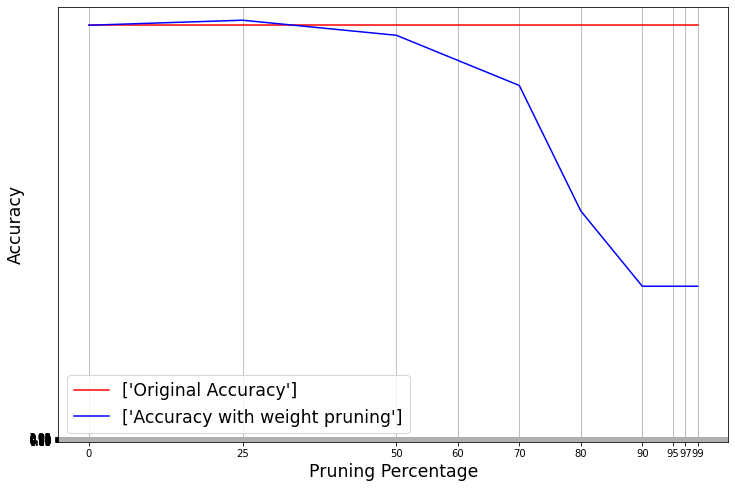

In [ ]:
original_accuracy = 83
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
plt.plot(pruning_percent, np.size(pruning_percent)*[original_accuracy], 'r',
         pruning_percent, accuracy_weight_pruning, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(pruning_percent)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()